# Importing regular package

In [1]:
import torch, torchvision, os, copy
import pandas as pd
from PIL import Image
import pickle

import numpy as np

import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms

from torchsummary import summary


import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time

# Defining configuration

In [2]:
max_epochs = 1000
batch_size = 64
LR = 0.0001

dataset_folder = "dataset"

noise_magnitude = 0

# Defining transformation to adapt the feet dataset to the ImageNet format

In [3]:
normalization_tranform = transforms.Compose([
    #Resizing the image
    transforms.Resize(256),
    #Center crop
    transforms.CenterCrop(224),
    #Adapting to torch tensor
    transforms.ToTensor(),
    #Normalizing to ImageNet
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loading the pretrained model

In [4]:
pretrain_model = torchvision.models.resnet50(pretrained=True)

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

for param in pretrain_model.parameters():
    param.requires_grad = False

# Loading the images and extracting the vector of extracted features

In [5]:
def load_folder(folder):
    data = []
    labels = []
    for img_file in tqdm(os.listdir(folder)):
        if(img_file[-4:] == ".jpg"):
            img = Image.open(folder+"/"+ img_file)
            #feature extraction
            k = normalization_tranform(img).view(-1, 3, 224, 224)
            result = pretrain_model(k).view(-1)
            #End of feature extraction
            data.append(result)
        else:#The xml file
            label = np.zeros((2))
            with open(folder+"/"+ img_file, "r") as fa:
                v = fa.read().split("<name>")[1].split("</name>")[0]
                if(v == "Infection and Ischaemia"):
                    label[0] = 1
                    label[1] = 1
                elif(v == "Infection"):
                    label[0] = 1
                elif(v == "Ischaemia"):
                    label[1] = 1
            labels.append(torch.from_numpy(label))

    label_tensor =  torch.stack(labels).view(-1, 2).float()
    data_tensor = torch.stack(data)
    return data_tensor, label_tensor


x_train, y_train = load_folder(dataset_folder+"/train")

Widget Javascript not detected.  It may not be installed or enabled properly.


### Same for the test set.

In [6]:
x_test, y_test = load_folder(dataset_folder+"/test")

Widget Javascript not detected.  It may not be installed or enabled properly.


## Creating the dataloader

In [7]:
train_dataloader = DataLoader(TensorDataset(x_train,y_train), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=True)

## Creating the trainable part

In [8]:
class TrainableModel(nn.Module):
    """
    Quantum network module.
    """
    
    def __init__(self):
        """
        Defining quantum layer structure
        """
        super().__init__()
        
        #Starting with a batch normalization
        self.entry_norm = nn.BatchNorm1d(1000)
        self.fc1 = nn.Linear(1000, 2)
        
    def forward(self, x):
        """
        Defining dataflow in the quantum layer
        """
        
        #normalizing data with the batch normalization
        x = self.entry_norm(x)
        #dimensionality reduction
        x = self.fc1(x)
        
        return torch.sigmoid(x)

## Creating the neural network

In [9]:
basic_architecture = TrainableModel()
summary(basic_architecture, input_size=(1000,), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                 [-1, 1000]           2,000
            Linear-2                    [-1, 2]           2,002
Total params: 4,002
Trainable params: 4,002
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [10]:
opti_basic = optim.Adam(basic_architecture.parameters(), lr=LR)
criterion = nn.MSELoss()

## Training the model

In [11]:
best_loss = float("inf")
best_classical_model = copy.deepcopy(basic_architecture.state_dict())
loss_history_classical = []
val_loss_history_classical = []
basic_confusion_history = []

for epoch in range(1, max_epochs + 1):
    
    tracking_loss = 0.0
    
    print("Epoch "+str(epoch), end="\r")
    
    for batch_id, (data, labels) in enumerate(train_dataloader):
        #reseting optimizer
        opti_basic.zero_grad()
        
        #Adding noise to entry
        data = data + (torch.rand((data.shape[0], data.shape[1])) - 0.5) * noise_magnitude
        #Moving data and labels to GPU if needed
        
        #Performing inference
        predictions = basic_architecture(data)
        
        #Computing loss
        loss = criterion(predictions, labels.view(-1, 2))
        #Backpropagate
        loss.backward()
        #Update optimizer
        opti_basic.step()

        #Adding loss
        tracking_loss += loss.item() * len(labels)
        print("Epoch "+str(epoch)+": Training at "+str(int(batch_id/len(train_dataloader)*100))+"%", end="\r")
        
    loss_history_classical.append(tracking_loss / len(train_dataloader))
    
    tracking_val_loss = 0.0
    
    #Since we train, there is no need of keep track of the gradients. This speeds up the training process.
    with torch.no_grad():
        true_labels = []
        basic_pred = []
        for batch_id, (data, labels) in enumerate(test_dataloader):
            
            #Moving data and labels to GPU if needed
            true_labels = true_labels + labels.tolist()

            #Performing inference
            predictions = basic_architecture(data)

            #Computing loss
            loss = criterion(predictions, labels)
            base_predictions = predictions.detach()
            base_predictions = torch.where(base_predictions > 0.5,
                                           torch.ones_like(base_predictions),
                                           torch.zeros_like(base_predictions)).tolist()
            basic_pred = basic_pred + base_predictions

            #Adding loss
            tracking_val_loss += loss.item() * len(labels)
            print("Epoch "+str(epoch)+": Training done. Testing at "+str(int(batch_id/len(test_dataloader)*100))+"%", end="\r")
        
        val_loss_history_classical.append(tracking_val_loss / len(test_dataloader))
        
        if(best_loss > tracking_val_loss / len(test_dataloader)):
            best_loss = tracking_val_loss / len(test_dataloader)
            best_classical_model = copy.deepcopy(basic_architecture.state_dict())
            torch.save(best_classical_model, "best_classical_model_resnet50")
    
    print("Epoch "+str(epoch))
    print("\tloss:",tracking_loss / len(train_dataloader),"\n\tval_loss:", tracking_val_loss / len(test_dataloader))

Epoch 1: Training done. Testing at 0%
	loss: 16.854551509022713 
	val_loss: 6.3851258754730225
Epoch 2: Training done. Testing at 0%
	loss: 16.311848610639572 
	val_loss: 6.238152265548706
Epoch 3: Training done. Testing at 0%
	loss: 16.067451290786266 
	val_loss: 6.11556601524353
Epoch 4: Training done. Testing at 0%
	loss: 15.791720889508724 
	val_loss: 6.018547296524048
Epoch 5: Training done. Testing at 0%
	loss: 15.543142326176167 
	val_loss: 5.938793778419495
Epoch 6: Training done. Testing at 0%
	loss: 15.435065887868404 
	val_loss: 5.874841690063477
Epoch 7: Training done. Testing at 0%
	loss: 15.161069460213184 
	val_loss: 5.8293696641922
Epoch 8: Training done. Testing at 0%
	loss: 14.965751770883799 
	val_loss: 5.787895202636719
Epoch 9: Training done. Testing at 0%
	loss: 14.845313247293234 
	val_loss: 5.75924026966095
Epoch 10: Training done. Testing at 0%
	loss: 14.795842595398426 
	val_loss: 5.744205594062805
Epoch 11: Training done. Testing at 0%
	loss: 14.5827133208513

Epoch 91: Training done. Testing at 0%
	loss: 8.309256259351969 
	val_loss: 4.961037755012512
Epoch 92: Training done. Testing at 0%
	loss: 8.230861559510231 
	val_loss: 4.9627121686935425
Epoch 93: Training done. Testing at 0%
	loss: 8.071281356737018 
	val_loss: 4.958340167999268
Epoch 94: Training done. Testing at 0%
	loss: 8.094154320657253 
	val_loss: 4.959512829780579
Epoch 95: Training done. Testing at 0%
	loss: 8.079372385516763 
	val_loss: 4.953677773475647
Epoch 96: Training done. Testing at 0%
	loss: 7.997257761657238 
	val_loss: 4.945677638053894
Epoch 97: Training done. Testing at 0%
	loss: 8.05708822235465 
	val_loss: 4.937266945838928
Epoch 98: Training done. Testing at 0%
	loss: 7.836331956088543 
	val_loss: 4.937699317932129
Epoch 99: Training done. Testing at 0%
	loss: 7.907587122172117 
	val_loss: 4.94412624835968
Epoch 100: Training done. Testing at 0%
	loss: 7.8059677835553885 
	val_loss: 4.940162658691406
Epoch 101: Training done. Testing at 0%
	loss: 7.7777175791

Epoch 182: Training done. Testing at 0%
	loss: 5.328463055193424 
	val_loss: 4.977174282073975
Epoch 183: Training done. Testing at 0%
	loss: 5.223000422120094 
	val_loss: 4.979264259338379
Epoch 184: Training done. Testing at 0%
	loss: 5.3123001717031 
	val_loss: 4.9836273193359375
Epoch 185: Training done. Testing at 0%
	loss: 5.190187677741051 
	val_loss: 4.988788962364197
Epoch 186: Training done. Testing at 0%
	loss: 5.190134858712554 
	val_loss: 4.995722651481628
Epoch 187: Training done. Testing at 0%
	loss: 5.244546256959438 
	val_loss: 5.001248002052307
Epoch 188: Training done. Testing at 0%
	loss: 5.3476043455302715 
	val_loss: 5.011087775230408
Epoch 189: Training done. Testing at 0%
	loss: 5.18385854549706 
	val_loss: 5.0179338455200195
Epoch 190: Training done. Testing at 0%
	loss: 5.139300737529993 
	val_loss: 5.020036697387695
Epoch 191: Training done. Testing at 0%
	loss: 5.234853006899357 
	val_loss: 5.024714827537537
Epoch 192: Training done. Testing at 0%
	loss: 5.1

Epoch 268: Training done. Testing at 0%
	loss: 3.9438704205676913 
	val_loss: 5.268268704414368
Epoch 269: Training done. Testing at 0%
	loss: 3.9459185684099793 
	val_loss: 5.266956210136414
Epoch 270: Training done. Testing at 0%
	loss: 3.894252013415098 
	val_loss: 5.264816164970398
Epoch 271: Training done. Testing at 0%
	loss: 3.819735251367092 
	val_loss: 5.267039895057678
Epoch 272: Training done. Testing at 0%
	loss: 3.7805637307465076 
	val_loss: 5.269702792167664
Epoch 273: Training done. Testing at 0%
	loss: 3.9220241978764534 
	val_loss: 5.2717612981796265
Epoch 274: Training done. Testing at 0%
	loss: 3.813760492950678 
	val_loss: 5.273829102516174
Epoch 275: Training done. Testing at 0%
	loss: 3.777075990103185 
	val_loss: 5.273447155952454
Epoch 276: Training done. Testing at 0%
	loss: 3.828993615694344 
	val_loss: 5.278274416923523
Epoch 277: Training done. Testing at 0%
	loss: 3.826278105378151 
	val_loss: 5.289437770843506
Epoch 278: Training done. Testing at 0%
	loss

Epoch 354: Training done. Testing at 0%
	loss: 3.0587665010243654 
	val_loss: 5.542835712432861
Epoch 355: Training done. Testing at 0%
	loss: 3.284401984885335 
	val_loss: 5.545742154121399
Epoch 356: Training done. Testing at 0%
	loss: 2.9190767416730523 
	val_loss: 5.553303837776184
Epoch 357: Training done. Testing at 0%
	loss: 2.868356216698885 
	val_loss: 5.564898133277893
Epoch 358: Training done. Testing at 0%
	loss: 2.893125276081264 
	val_loss: 5.567363619804382
Epoch 359: Training done. Testing at 0%
	loss: 2.8657527081668377 
	val_loss: 5.56656539440155
Epoch 360: Training done. Testing at 0%
	loss: 2.860856863670051 
	val_loss: 5.570022225379944
Epoch 361: Training done. Testing at 0%
	loss: 2.98402641993016 
	val_loss: 5.565962791442871
Epoch 362: Training done. Testing at 0%
	loss: 2.8575171818956733 
	val_loss: 5.565958857536316
Epoch 363: Training done. Testing at 0%
	loss: 2.8246537521481514 
	val_loss: 5.568579196929932
Epoch 364: Training done. Testing at 0%
	loss: 

Epoch 442: Training done. Testing at 0%
	loss: 2.3038607137277722 
	val_loss: 5.840951442718506
Epoch 443: Training done. Testing at 0%
	loss: 2.2145656859502196 
	val_loss: 5.841320514678955
Epoch 444: Training done. Testing at 0%
	loss: 2.4400879610329866 
	val_loss: 5.841260075569153
Epoch 445: Training done. Testing at 0%
	loss: 2.3682110887020826 
	val_loss: 5.8404436111450195
Epoch 446: Training done. Testing at 0%
	loss: 2.3849586555734277 
	val_loss: 5.843224883079529
Epoch 447: Training done. Testing at 0%
	loss: 2.1904289284721017 
	val_loss: 5.840732574462891
Epoch 448: Training done. Testing at 0%
	loss: 2.1962760807946324 
	val_loss: 5.839128613471985
Epoch 449: Training done. Testing at 0%
	loss: 2.2173619838431478 
	val_loss: 5.837465286254883
Epoch 450: Training done. Testing at 0%
	loss: 2.2136220103129745 
	val_loss: 5.843792080879211
Epoch 451: Training done. Testing at 0%
	loss: 2.1606735289096832 
	val_loss: 5.846643090248108
Epoch 452: Training done. Testing at 0%

Epoch 528: Training done. Testing at 0%
	loss: 1.8326911726035178 
	val_loss: 6.064513921737671
Epoch 529: Training done. Testing at 0%
	loss: 1.80965893343091 
	val_loss: 6.065851449966431
Epoch 530: Training done. Testing at 0%
	loss: 1.7150911893695593 
	val_loss: 6.071142911911011
Epoch 531: Training done. Testing at 0%
	loss: 1.934510632418096 
	val_loss: 6.079993486404419
Epoch 532: Training done. Testing at 0%
	loss: 1.7659975243732333 
	val_loss: 6.087424278259277
Epoch 533: Training done. Testing at 0%
	loss: 1.77610716316849 
	val_loss: 6.084981679916382
Epoch 534: Training done. Testing at 0%
	loss: 1.7542132786475122 
	val_loss: 6.090697288513184
Epoch 535: Training done. Testing at 0%
	loss: 1.8027728591114283 
	val_loss: 6.091484069824219
Epoch 536: Training done. Testing at 0%
	loss: 1.692506970372051 
	val_loss: 6.097006559371948
Epoch 537: Training done. Testing at 0%
	loss: 1.7279777312651277 
	val_loss: 6.103802919387817
Epoch 538: Training done. Testing at 0%
	loss:

Epoch 615: Training done. Testing at 0%
	loss: 1.4755785935558379 
	val_loss: 6.29684042930603
Epoch 616: Training done. Testing at 0%
	loss: 1.4009528560563922 
	val_loss: 6.3008036613464355
Epoch 617: Training done. Testing at 0%
	loss: 1.4661552179604769 
	val_loss: 6.300292253494263
Epoch 618: Training done. Testing at 0%
	loss: 1.3908508117310703 
	val_loss: 6.306809663772583
Epoch 619: Training done. Testing at 0%
	loss: 1.4984652157872915 
	val_loss: 6.317328214645386
Epoch 620: Training done. Testing at 0%
	loss: 1.336682460270822 
	val_loss: 6.316580057144165
Epoch 621: Training done. Testing at 0%
	loss: 1.3878406973090023 
	val_loss: 6.315640211105347
Epoch 622: Training done. Testing at 0%
	loss: 1.5002559376880527 
	val_loss: 6.322380781173706
Epoch 623: Training done. Testing at 0%
	loss: 1.3758341846987605 
	val_loss: 6.330301523208618
Epoch 624: Training done. Testing at 0%
	loss: 1.4795598946511745 
	val_loss: 6.327343225479126
Epoch 625: Training done. Testing at 0%
	

Epoch 706: Training done. Testing at 0%
	loss: 1.1590843917801976 
	val_loss: 6.49906325340271
Epoch 707: Training done. Testing at 0%
	loss: 1.3385034324601293 
	val_loss: 6.5081212520599365
Epoch 708: Training done. Testing at 0%
	loss: 1.1376482946798205 
	val_loss: 6.518519639968872
Epoch 709: Training done. Testing at 0%
	loss: 1.0893238852731884 
	val_loss: 6.5301432609558105
Epoch 710: Training done. Testing at 0%
	loss: 1.1694641159847379 
	val_loss: 6.527734994888306
Epoch 711: Training done. Testing at 0%
	loss: 1.0967252082191408 
	val_loss: 6.529945135116577
Epoch 712: Training done. Testing at 0%
	loss: 1.2103545060381293 
	val_loss: 6.530905723571777
Epoch 713: Training done. Testing at 0%
	loss: 1.1934269573539495 
	val_loss: 6.533470630645752
Epoch 714: Training done. Testing at 0%
	loss: 1.287258598022163 
	val_loss: 6.5299272537231445
Epoch 715: Training done. Testing at 0%
	loss: 1.1995809527579695 
	val_loss: 6.522888422012329
Epoch 716: Training done. Testing at 0%

Epoch 794: Training done. Testing at 0%
	loss: 1.0871238089166582 
	val_loss: 6.69731068611145
Epoch 795: Training done. Testing at 0%
	loss: 0.8728219384793192 
	val_loss: 6.702932596206665
Epoch 796: Training done. Testing at 0%
	loss: 0.9813394085504115 
	val_loss: 6.704437494277954
Epoch 797: Training done. Testing at 0%
	loss: 0.9475173156242818 
	val_loss: 6.705540418624878
Epoch 798: Training done. Testing at 0%
	loss: 0.8675471036694944 
	val_loss: 6.705181360244751
Epoch 799: Training done. Testing at 0%
	loss: 0.9638756671920419 
	val_loss: 6.707234144210815
Epoch 800: Training done. Testing at 0%
	loss: 1.0232166908681393 
	val_loss: 6.7072484493255615
Epoch 801: Training done. Testing at 0%
	loss: 0.9227026230655611 
	val_loss: 6.71133828163147
Epoch 802: Training done. Testing at 0%
	loss: 0.8706914021167904 
	val_loss: 6.714235067367554
Epoch 803: Training done. Testing at 0%
	loss: 0.9964861331973225 
	val_loss: 6.717991590499878
Epoch 804: Training done. Testing at 0%
	

Epoch 880: Training done. Testing at 0%
	loss: 0.8331449776887894 
	val_loss: 6.844335079193115
Epoch 881: Training done. Testing at 0%
	loss: 0.7812369612511247 
	val_loss: 6.848879814147949
Epoch 882: Training done. Testing at 0%
	loss: 0.8051454266533256 
	val_loss: 6.852624177932739
Epoch 883: Training done. Testing at 0%
	loss: 0.750313678290695 
	val_loss: 6.8611743450164795
Epoch 884: Training done. Testing at 0%
	loss: 0.75173759018071 
	val_loss: 6.864438772201538
Epoch 885: Training done. Testing at 0%
	loss: 0.758768949424848 
	val_loss: 6.8701536655426025
Epoch 886: Training done. Testing at 0%
	loss: 0.7318265177309513 
	val_loss: 6.869868278503418
Epoch 887: Training done. Testing at 0%
	loss: 0.794995759613812 
	val_loss: 6.87250542640686
Epoch 888: Training done. Testing at 0%
	loss: 0.762935642618686 
	val_loss: 6.881920337677002
Epoch 889: Training done. Testing at 0%
	loss: 0.8915914129465818 
	val_loss: 6.882949590682983
Epoch 890: Training done. Testing at 0%
	loss

Epoch 968: Training done. Testing at 0%
	loss: 0.7288892904762179 
	val_loss: 7.0101234912872314
Epoch 969: Training done. Testing at 0%
	loss: 0.6207748642191291 
	val_loss: 7.014218330383301
Epoch 970: Training done. Testing at 0%
	loss: 0.8194397687911987 
	val_loss: 7.0116870403289795
Epoch 971: Training done. Testing at 0%
	loss: 0.641215851996094 
	val_loss: 7.006657361984253
Epoch 972: Training done. Testing at 0%
	loss: 0.654573364648968 
	val_loss: 7.000863075256348
Epoch 973: Training done. Testing at 0%
	loss: 0.6131839137524366 
	val_loss: 7.004878520965576
Epoch 974: Training done. Testing at 0%
	loss: 0.7727744451258332 
	val_loss: 7.011142730712891
Epoch 975: Training done. Testing at 0%
	loss: 0.6700717308558524 
	val_loss: 7.020161390304565
Epoch 976: Training done. Testing at 0%
	loss: 0.6626002606935799 
	val_loss: 7.018829584121704
Epoch 977: Training done. Testing at 0%
	loss: 0.666986306430772 
	val_loss: 7.0220654010772705
Epoch 978: Training done. Testing at 0%


## Ploting loss performance on test set

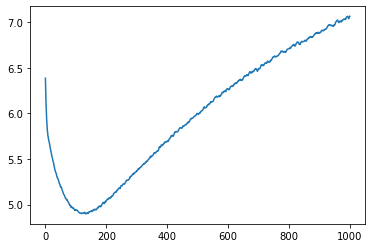

In [12]:
plt.plot(val_loss_history_classical) #Noise = 0

In [13]:
## Loading best model
basic_architecture.load_state_dict(torch.load("best_classical_model_resnet50"))

<All keys matched successfully>

## Detailing performances

In [14]:
y_pred = basic_architecture(x_test).detach().numpy()
y_pred = np.where(y_pred > 0.5, 1, 0)

In [15]:
infection_found = 0
total_infection = 0
ischaemia_found = 0
total_ischemia = 0

non_ischaemia = 0
total_non_ischaemia = 0
non_infection = 0
total_non_infection = 0

for yp, yt in zip(y_pred, y_test):
    if(yt[0] == 1):
        total_infection += 1
        if(yp[0] == 1):
            infection_found += 1
    else:
        total_non_ischaemia += 1
        if(yp[0] == 0):
            non_ischaemia += 1
        
    if(yt[1] == 1):
        total_ischemia += 1
        if(yp[1] == 1):
            ischaemia_found += 1
    else:
        total_non_infection += 1
        if(yp[1] == 1):
            non_infection += 1

In [16]:
print(("Infection found : %.2f" % (infection_found*100/total_infection))+"%")
print(("TN infection found : %.2f" % (non_infection*100/total_non_infection))+"%")
print(("Ischemia found : %.2f" % (ischaemia_found*100/total_ischemia))+"%")
print(("TN ischemia found : %.2f" % (non_ischaemia*100/total_non_ischaemia))+"%")

Infection found : 95.88%
TN infection found : 75.00%
Ischemia found : 96.47%
TN ischemia found : 80.00%
